## BLAS Methods FLOPS/s Comparison
Matthew Cheung

### Introduction

Matrix Multiplication or Matrix Product is an operation that produces a matrix from two matrices. 

If $A\in \mathbb{R}^{m\times p}$ represented by

\begin{gather}
A =
\begin{bmatrix}
    a_{11} & a_{12} & a_{13} & \dots  & a_{1n} \\
    a_{21} & a_{22} & a_{23} & \dots  & a_{2n} \\
    \vdots & \vdots & \vdots & \ddots & \vdots \\
    a_{m1} & a_{m2} & a_{m3} & \dots  & a_{mn}
\end{bmatrix}
\end{gather}


and $B\in \mathbb{R}^{p\times n}$ represented by

\begin{gather}
B =
\begin{bmatrix}
    b_{11} & b_{12} & b_{13} & \dots  & b_{1n} \\
    b_{21} & b_{22} & b_{23} & \dots  & b_{2n} \\
    \vdots & \vdots & \vdots & \ddots & \vdots \\
    b_{p1} & b_{p2} & b_{p3} & \dots  & b_{pn}
\end{bmatrix}
\end{gather}



then the Matrix Product can be defined as $C = AB$ where $$c_{ij} = \sum^m_{k=1}a_{ik}b_{kj} \quad 1\leq i \leq n\ , 1\leq j \leq p$$


\begin{gather}
C = AB = 
\begin{bmatrix}
    c_{11} & c_{12} & c_{13} & \dots  & c_{1n} \\
    c_{21} & c_{22} & c_{23} & \dots  & c_{2n} \\
    \vdots & \vdots & \vdots & \ddots & \vdots \\
    c_{m1} & c_{m2} & c_{m3} & \dots  & c_{mn}
\end{bmatrix}
\end{gather}

Computing the matrix product of two matrices has a computational complexity of $O(n^3)$ for $n\times n$ matrices and hence slow. Different algorithms have been devised for computing the matrix product for large matrices. In this project, a survey of methods that take computer architecture into account will be explored.

### Computing Bottleneck

The time to run a program can be modeled by:

$$ Time\;to\;run\;code\;=\;clock\;cycles\;running\;code\;+\;clock\;cycles\;waiting\;for\;memory $$

The improvement rate in processor speed (Moore's Law, ~60%/yr) exceeds that of DRAM memory (~7%/yr). There is a growing latency between the state of the art proessor speed and memory access speed (~53%/yr). Therefore, the bottleneck for computing is memory access and not the number of arithmetic operations.

To model this, we can define a simple memory model with two levels - fast and slow memories. All the data is initially in slow memory. Data is processed faster if in the fast memory. Therefore, Data needs to be transferred from slow to fast memory before each subroutine. The performance metric is the number of floating point operations per slow element access, called FLOPS.


### Basic Linear Algebra Subprograms (BLAS)

BLAS are low-level kernels that provide routines for performing Linear Algebra operations such as matrix addition, multiplication and dot products. These routines tend to be optimized for particular machines. These are the standard building blocks in modern linear algebra software.

BLAS separates its functionality into three levels: BLAS-1, BLAS-2 and BLAS-3. BLAS-1 performs scalar, vector and vector-vector operations. BLAS-2 performs matrix-vector operations. BLAS-3 performs matrix-matrix operations. A summary table of performance metrics is shown below:




\begin{array}{rr} \hline
BLAS &Memory References &FLOPS & FLOPS/Memory References \\ \hline
1 & 3n & 2n & 2/3 \\ \hline
2 & n^2 & 2n^2 & 2 \\ \hline
3 & 4n^2 & 2n^3 & n/2
\end{array}

### Experiment Methods

Five different algorithms for matrix multiplication will be tested and compared with FLOP rate for square matrices. The size of the matrix (n) will be varied and plotted versus MFLOPS/s. In this case, 10 values from 10 to 500 were selected using the numpy linspace function.

The MFLOPS/s will be computed using the equation: $ MFLOPS/s = \frac{2n^3}{10^6 \times runtime}$

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

#### 1. Triple Loop
The triple loop is the element wise (naïve) multiplication, which is mentioned in the introduction as $$c_{ij} = \sum^m_{k=1}a_{ik}b_{kj} \quad 1\leq i \leq n\ , 1\leq j \leq p$$

In [105]:
def matmul_triple(A, B):
    [m, p, n] = mat2_shape(A, B)
    C = np.zeros((m, n))
    for i in range(m):
        for j in range(n):
            for k in range(p):
                C[i, j] = C[i, j] + A[i, k]*B[k, j]
    return C

#### 2. Dot Product (BLAS-1)
The dot product of two vectors $a = [a_1, a_2, \dots, a_n]$ and $b = [b_1, b_2, \dots, b_n]$ is defined as $$a\cdot b = \sum^n_{i=1}a_i b_i$$

The implementation of using the dot product for matrix multiplication is $$c_{ij} = a_{i}\cdot b_{j} \quad 1\leq i \leq m\ , 1\leq j \leq n$$

In [107]:
def matmul_dot(A, B):
    [m, p, n] = mat2_shape(A, B)
    C = np.zeros((m, n))
    for i in range(m):
        for j in range(n):
            C[i, j] = C[i, j] + np.dot(A[i, :], B[:, j])
    return C

#### 3. Saxpy (BLAS-1)
Saxpy (Single-Precision A X Plus Y) is defined as the form $y:=ax + y$, where $x,y$ are vectors and $a$ is a scalar. The implementation of saxpy for matrix multiplication is $$c_i = c_i + a_j b_{ji} \quad 1\leq i \leq m\ , 1\leq j \leq p$$

In [118]:
def matmul_saxpy(A, B):
    [m, p, n] = mat2_shape(A, B)
    C = np.zeros((m, n))
    for i in range(m):
        for j in range(p):
            C[:, i] = C[:, i] + A[:, j]*B[j, i]
    return C

#### 4. Matrix-Vector (BLAS-2)
Matrix-Vector multiplication is defined as $y:=y+Ax$ where A is matrix and x is a vector. The implementation for Matrix-Vector matrix multiplication is $$c_k = c_k + Ab_k \quad 1\leq k \leq n$$

In [119]:
def matmul_matvec(A, B):
    [m, n, p] = mat2_shape(A, B)
    C = np.zeros((m, n))
    for k in range(n):
        C[:, k] = C[:, k] + np.matmul(A[:, :], B[:, k])
    return C

#### 5. Outer product (BLAS-2)
The outer product is defined as $a\otimes b = ab^T$ If a and b have dimensions of m and n, then their outer product is an m by n matrix. The implementation of the outer product matrix multiplication is defined as $$C = C + a_i b^T_i$$

In [120]:
def matmul_outer(A, B):
    [m, n, p] = mat2_shape(A, B)
    C = np.zeros((m, n))
    for i in range(p):
        C[:, :] = C[:, :] + np.outer(A[:, i], B[i, :])
    return C

#### Misc Function(s)

In [121]:
def mat2_shape(A, B):
    [m, p] = A.shape
    [m, n] = B.shape
    return m, p, n

#### Get running time routine

In [122]:
funcs = ['matmul_triple', 'matmul_dot', 'matmul_saxpy',
         'matmul_matvec', 'matmul_outer']
func_names = ['triple loop', 'dot product (BLAS-1)', 'saxpy (BLAS-1)',
         'matrix-vector (BLAS-2)', 'outer product (BLAS-2)']
n = np.linspace(10, 500, 10)
t = np.rint(np.zeros((len(n), len(funcs))))
for i in range(len(n)):
    size = int(n[i])
    A = np.random.rand(size, size)
    B = np.random.rand(size, size)
    for j in range(len(funcs)):
        start_time = time.time()
        C = eval(funcs[j] + '(A, B)')
        t[i, j] = time.time() - start_time

#### Get FLOPS/s routine

In [80]:
flops = np.zeros((t.shape[0], t.shape[1]))
for i in range(t.shape[0]):
    flops[i, :] = 2*(n[i]**3)/t[i, :]/(1e6)

### Experiment Results

#### Run Time Comparison

In [81]:
dispt = np.zeros((t.shape[0], t.shape[1] + 1))
dispt[:, 0] = np.round(n).astype('int')
dispt[:, 1:] = t
df_t = pd.DataFrame(dispt, columns = np.append(['n'], func_names))
df_t['n'] = df_t['n'].astype(int)
df_t

,n,triple loop,dot product (BLAS-1),saxpy (BLAS-1),matrix-vector (BLAS-2),outer product (BLAS-2)
0,10,0.001958,0.000494,0.001043,0.000294,0.000350
1,64,0.324073,0.007775,0.028444,0.000872,0.002727
2,119,2.483323,0.056787,0.104679,0.000967,0.008148
3,173,7.373535,0.110846,0.270866,0.002401,0.019772
4,228,16.292575,0.119387,0.522254,0.004367,0.040190
5,282,28.353514,0.195107,0.848704,0.005697,0.071406
6,337,49.096077,0.392282,1.279814,0.007889,0.109456
7,391,76.775584,0.513610,1.959762,0.012160,0.248771
8,446,113.867998,0.725625,2.673684,0.018931,0.330257
9,500,161.462556,0.949153,3.341192,0.023851,0.473899


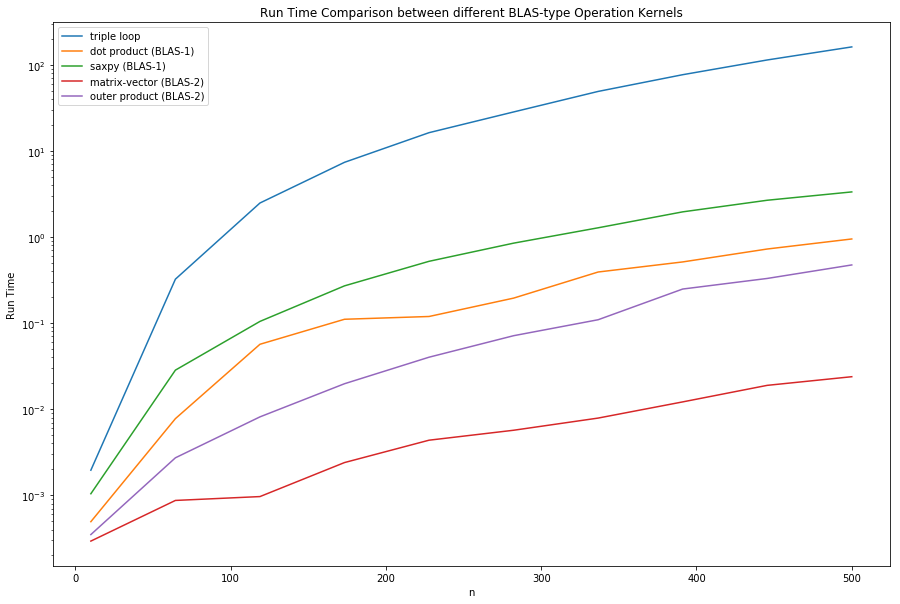

In [100]:
plt.figure(figsize = (15, 10))
plt.xlabel('n')
plt.ylabel('Run Time')
plt.title('Run Time Comparison between different BLAS-type Operation Kernels')
for i in range(t.shape[1]):
    plt.plot(n, t[:, i], label = func_names[i])
plt.legend()
plt.yscale('log', basey = 10)
plt.show()

#### MFLOPS/s Comparison

In [83]:
dispf = np.zeros((flops.shape[0], flops.shape[1] + 1))
dispf[:, 0] = np.round(n).astype('int')
dispf[:, 1:] = flops
df_f = pd.DataFrame(dispf, columns = np.append(['n'], func_names))
df_f['n'] = df_f['n'].astype(int)
df_f

,n,triple loop,dot product (BLAS-1),saxpy (BLAS-1),matrix-vector (BLAS-2),outer product (BLAS-2)
0,10,1.021506,4.048556,1.917396,6.803413,5.714311
1,64,1.651746,68.844448,18.818775,613.933586,196.289135
2,119,1.353383,59.184310,32.106561,3476.344810,412.482171
3,173,1.412539,93.962826,38.452263,4337.740537,526.774207
4,228,1.450689,197.973229,45.256638,5412.442808,588.093318
5,282,1.585611,230.425641,52.972115,7891.444145,629.604966
6,337,1.554474,194.550326,59.632566,9673.719498,697.253226
7,391,1.558502,232.968327,61.055832,9839.989620,480.983716
8,446,1.553581,243.794175,66.164569,9344.554011,535.652727
9,500,1.548347,263.392745,74.823590,10481.672148,527.538693


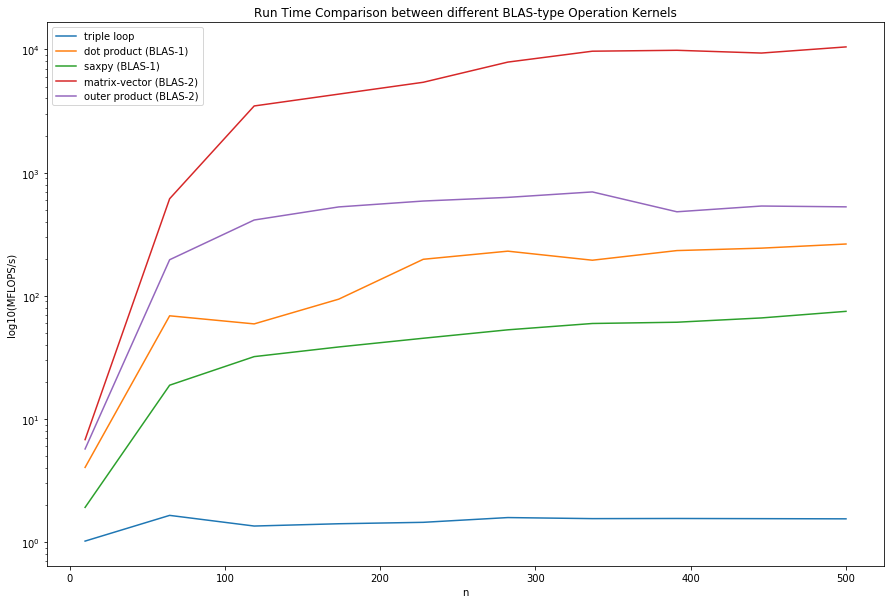

In [104]:
plt.figure(figsize = (15, 10))
plt.xlabel('n')
plt.ylabel('log10(MFLOPS/s)')
plt.title('Run Time Comparison between different BLAS-type Operation Kernels')
for i in range(t.shape[1]):
    plt.plot(n, flops[:, i], label = func_names[i])
plt.legend()
plt.yscale('log', basey = 10)
plt.show()

### Conclusion
From the collected data, the MFLOPS/s ranking was matrix-vector, outer product, dot product, saxpy and triple loop. The rankings were expected because BLAS-2 were theorized to be faster than BLAS-1 and both were theorzied to be faster than the triple loop due to the number of FLOPS/MemoryReferences. The curves plotted were consistent with the expected shape - as the size of the matrix gets larger and larger, the MFLOPS/s eventually plateaus. This wil be more evident as the size of the matrix gets larger and larger. The maximum MFLOPS/s for each of the methods is shown below

In [98]:
df_f_max = df_f.max()[1::].to_frame()
df_f_max.columns = ['Maximum MFLOPS/s']
df_f_max

,Maximum MFLOPS/s
triple loop,1.651746
dot product (BLAS-1),263.392745
saxpy (BLAS-1),74.823590
matrix-vector (BLAS-2),10481.672148
outer product (BLAS-2),697.253226


### Discussion

Although it is evident that BLAS-2 is faster than BLAS-1, there is still some question to the ratios of MFLOPS/s between different methods. From the table in the introduction, BLAS-2 should be approximately $\frac{2}{2/3} = 3 $ times as fast as BLAS-1. These values makes sense if the comparison was done between dot product (BLAS-1) and outer product (BLAS-2), but does not make sense for any other combination. One reason that may have caused this is because the matrix was not large enough and did not plateau. Due to CPU speed and time limitations, more data was not be taken. Another experiment that collects more data points for larger matrix multiplications should be run. A percent change difference is computed below.

In [141]:
df_f_pct_change = df_f.groupby('n').mean().pct_change()
df_f_pct_change

,triple loop,dot product (BLAS-1),saxpy (BLAS-1),matrix-vector (BLAS-2),outer product (BLAS-2)
n,,,,,
10,NaN,NaN,NaN,NaN,NaN
64,0.616971,16.004692,8.814756,89.239061,33.350449
119,-0.180635,-0.140318,0.706092,4.662412,1.101401
173,0.043710,0.587631,0.197645,0.247788,0.277084
228,0.027008,1.106931,0.176956,0.247756,0.116405
282,0.093006,0.163923,0.170483,0.458019,0.070587
337,-0.019637,-0.155692,0.125735,0.225849,0.107446
391,0.002591,0.197471,0.023867,0.017188,-0.310174
446,-0.003157,0.046469,0.083673,-0.050349,0.113661


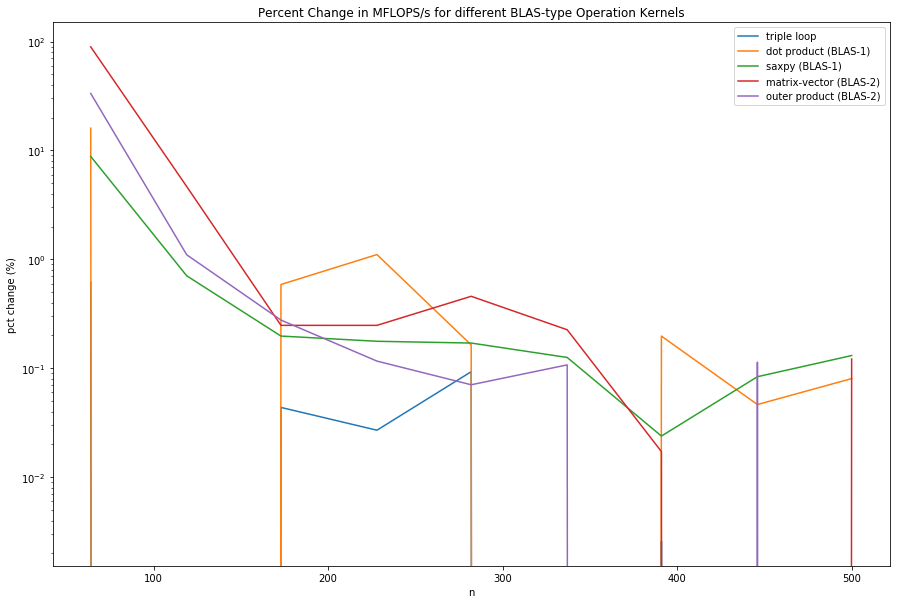

In [156]:
df_f_pct_change_ri = df_f_pct_change.reset_index()
plt.figure(figsize = (15, 10))
for i in df_f_pct_change_ri.columns:
    if i != 'n':
        plt.plot(df_f_pct_change_ri['n'], df_f_pct_change_ri[i])
plt.title('Percent Change in MFLOPS/s for different BLAS-type Operation Kernels')
plt.ylabel('pct change (%)')
plt.xlabel('n')
plt.yscale('log', basey = 10)
plt.legend()
plt.show()

From this, there is room for improvement, as the dot product and the matrix-vector kernels have a percentage change of greater than 10% at n = 500.

Another observation is that MATLAB behaves differently when the same kernels are implemented. It is unknown if it is an implementation problem or MATLAB's matrix multiplication routines. The MATLAB implementation is shown here https://pastebin.com/TL93T9mU and results are shown below

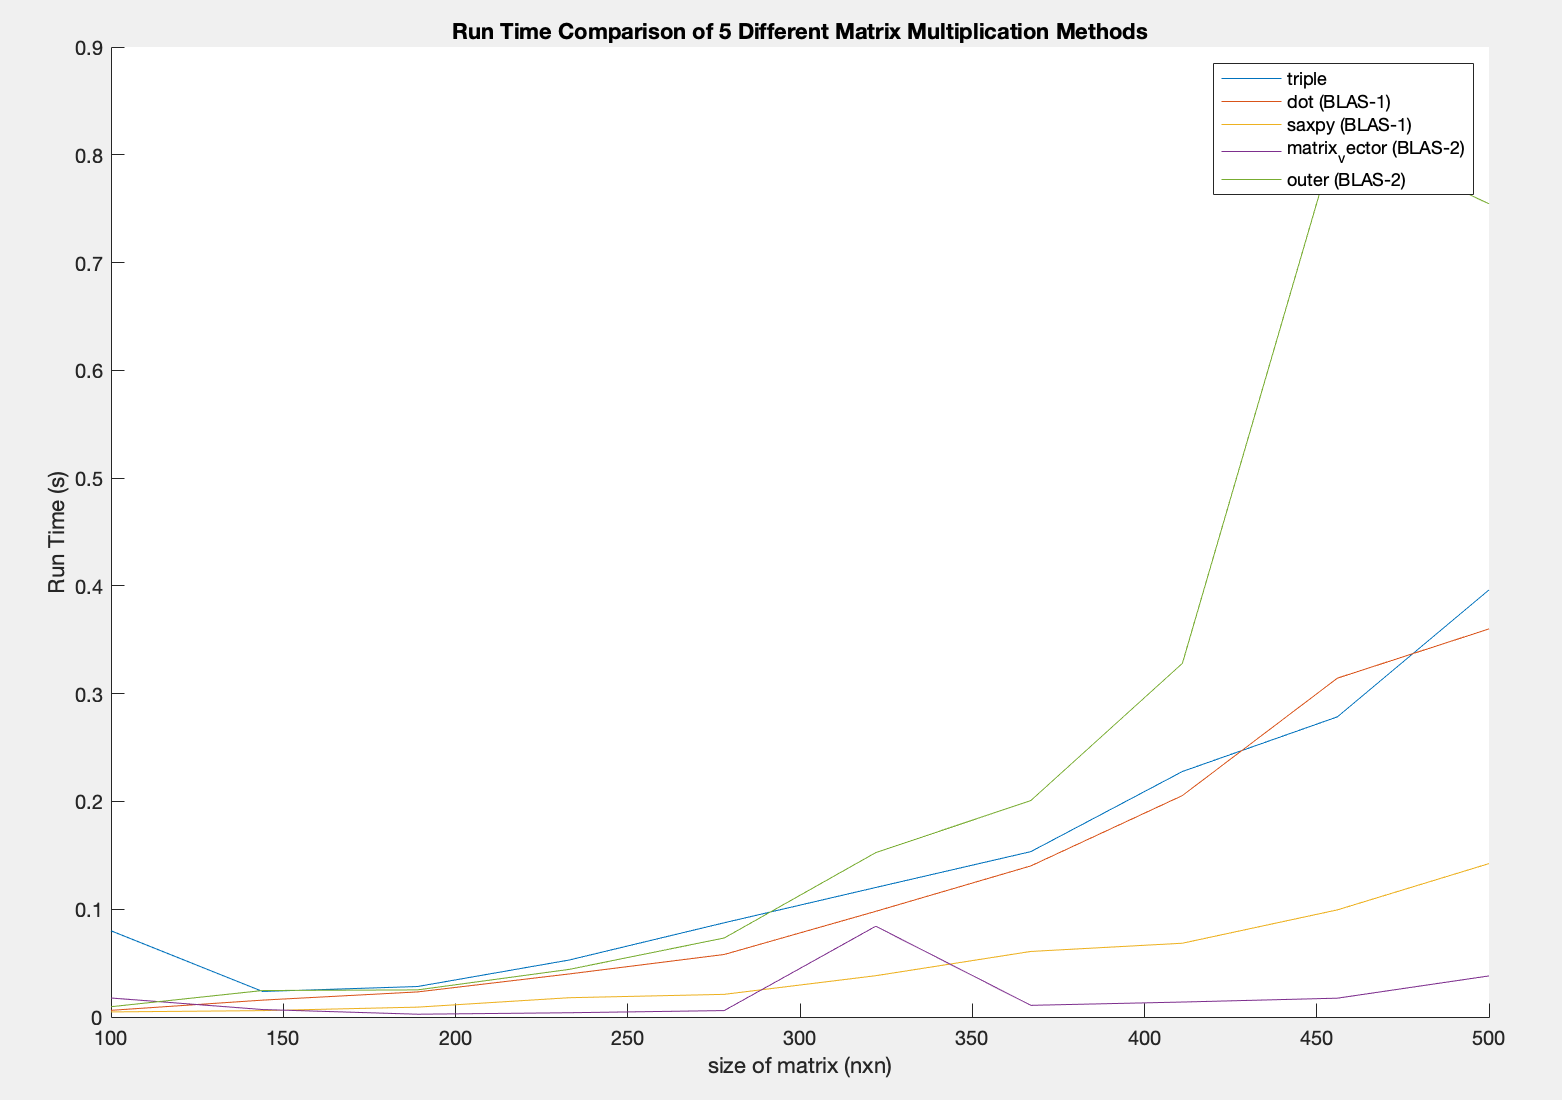

In [130]:
from IPython.display import Image
Image(filename='blas_comparison_matlab.png')

From the Run Time Comparison, we do not see the BLAS Run Time hierarchy. This may possibly be due to error in implementation. But the reason for this is still unknown.